<a href="https://colab.research.google.com/github/28nahidhasan/Thesis-Summer-24-25-/blob/main/Another_copy_of_thesis(summer_24_25)_inception_v3_(complete).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

nahidhasan28_thesis_path = kagglehub.dataset_download('nahidhasan28/thesis')
nahidhasan28_inception_v3_weights_keras_default_1_path = kagglehub.model_download('nahidhasan28/inception-v3-weights/Keras/default/1')

print('Data source import complete.')


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import pickle
from PIL import Image
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

print("Setup complete, TensorFlow version:", tf.__version__)


2025-07-30 14:20:46.095216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753885246.346547      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753885246.422935      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Setup complete, TensorFlow version: 2.18.0


#  Load and Verify Images

In [ ]:
dataset_path = '/kaggle/input/thesis/Thesis Pictures'
assert os.path.exists(dataset_path), "Dataset path missing!"

categories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
print("Categories found:", categories)

IMG_SIZE = (299, 299)
images, labels, image_metadata = [], [], []

for category in categories:
    cat_path = os.path.join(dataset_path, category)
    for fname in os.listdir(cat_path):
        fpath = os.path.join(cat_path, fname)
        if os.path.isdir(fpath):
            continue
        try:
            with Image.open(fpath) as img:
                img.verify()  # Verify it is an image
            img_cv = cv2.imread(fpath)
            if img_cv is not None:
                images.append(img_cv)
                labels.append(category)
                image_metadata.append({'file_path': fpath, 'label': category})
            else:
                print(f"Warning: could not load image by cv2: {fpath}")
        except Exception as e:
            print(f"Skipping invalid image {fpath}: {e}")

print(f"Total images loaded: {len(images)}")
gc.collect()


Categories found: ['Powdery mildew', 'Phytophthora bligh', 'Bacterial leaf spot', 'Cabbage looper', 'Bacterial wilt', 'Alternaria cucumerina', 'mosaic', 'Southern blight', 'Fusarium', 'Alternaria leaf blight', 'Gummy stem blight', 'Armyworms', 'Squash vine borer', 'Cucumber beetles', 'Squash bug', 'Aphids', 'Flea beetles', 'Thrips (Western flower thrips)']
Total images loaded: 1690


4

# Resize, Color Convert, Clean & Normalize Image

In [ ]:
# Resize images and convert BGR to RGB
images_resized = []
for img in images:
    resized = cv2.resize(img, IMG_SIZE)
    rgb_img = cv2.cvtColor(resized.astype(np.uint8), cv2.COLOR_BGR2RGB)
    images_resized.append(rgb_img)
images = np.array(images_resized)
del images_resized
gc.collect()
print(f"Resized images to {IMG_SIZE} and converted to RGB")

# Clean and Normalize images
valid_images, valid_labels, valid_meta = [], [], []
for img, lbl, meta in zip(images, labels, image_metadata):
    if img.shape == (299, 299, 3) and not np.isnan(img).any():
        valid_images.append(img)
        valid_labels.append(lbl)
        valid_meta.append(meta)
    else:
        print(f"Removing invalid image: {meta['file_path']}")

images = np.array(valid_images).astype(np.float32)
labels = np.array(valid_labels)
image_metadata = valid_meta

images /= 255.0
print(f"After cleaning, {len(images)} images remain")
gc.collect()


Resized images to (299, 299) and converted to RGB
After cleaning, 1690 images remain


0

# Crop and Pad images

In [ ]:
CROP_SIZE = (200, 200)
PAD_SIZE = IMG_SIZE  # (299, 299)

cropped_imgs = []
for img in images:
    h, w = img.shape[:2]
    start_x = (w - CROP_SIZE[0]) // 2
    start_y = (h - CROP_SIZE[1]) // 2
    cropped = img[start_y:start_y + CROP_SIZE[1], start_x:start_x + CROP_SIZE[0]]
    cropped_imgs.append(cropped)
images = np.array(cropped_imgs)
del cropped_imgs

padded_imgs = []
for img in images:
    h, w = img.shape[:2]
    top = (PAD_SIZE[1] - h) // 2
    bottom = PAD_SIZE[1] - h - top
    left = (PAD_SIZE[0] - w) // 2
    right = PAD_SIZE[0] - w - left
    padded = np.pad(img, ((top, bottom), (left, right), (0, 0)), mode='constant', constant_values=0)
    padded_imgs.append(padded)
images = np.array(padded_imgs)
del padded_imgs

print(f"Cropped images to {CROP_SIZE} and padded back to {PAD_SIZE}.")
gc.collect()


Cropped images to (200, 200) and padded back to (299, 299).


0

# Data Augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

num_aug_per_img = 2

augmented_images = []
augmented_labels = []

for i in range(len(images)):
    img = images[i].reshape((1, *images[i].shape))
    label = labels[i]
    it = datagen.flow(img, batch_size=1)
    for _ in range(num_aug_per_img):
        new_img = next(it)[0].astype(np.float32)
        augmented_images.append(new_img)
        augmented_labels.append(label)

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

print(f"Generated {len(augmented_images)} augmented images.")
gc.collect()

# Save original processed and augmented data
np.save('/kaggle/working/processed_images.npy', images)
np.save('/kaggle/working/processed_labels.npy', labels)

np.save('/kaggle/working/augmented_images.npy', augmented_images)
np.save('/kaggle/working/augmented_labels.npy', augmented_labels)

print("Saved processed and augmented images and labels to /kaggle/working/")

Generated 3380 augmented images.
Saved processed and augmented images and labels to /kaggle/working/


# Shuffle and label

In [ ]:
images, labels, image_metadata = shuffle(images, labels, image_metadata, random_state=42)

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

print("Label classes:", label_encoder.classes_)

np.save('/kaggle/working/labels_encoded.npy', labels_encoded)
with open('/kaggle/working/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

gc.collect()


Label classes: ['Alternaria cucumerina' 'Alternaria leaf blight' 'Aphids' 'Armyworms'
 'Bacterial leaf spot' 'Bacterial wilt' 'Cabbage looper'
 'Cucumber beetles' 'Flea beetles' 'Fusarium' 'Gummy stem blight'
 'Phytophthora bligh' 'Powdery mildew' 'Southern blight' 'Squash bug'
 'Squash vine borer' 'Thrips (Western flower thrips)' 'mosaic']


0

# Split Data (Augmented)

In [ ]:
train_aug_images, test_aug_images, train_aug_labels, test_aug_labels = train_test_split(
    augmented_images,
    label_encoder.transform(augmented_labels),
    test_size=0.2,
    random_state=42,
    stratify=label_encoder.transform(augmented_labels)
)

np.save('/kaggle/working/train_aug_images.npy', train_aug_images)
np.save('/kaggle/working/train_aug_labels.npy', train_aug_labels)
np.save('/kaggle/working/test_aug_images.npy', test_aug_images)
np.save('/kaggle/working/test_aug_labels.npy', test_aug_labels)

print(f"Augmented training images: {len(train_aug_images)}, Augmented testing images: {len(test_aug_images)}")

train_aug_dist = pd.Series(label_encoder.inverse_transform(train_aug_labels)).value_counts()
test_aug_dist = pd.Series(label_encoder.inverse_transform(test_aug_labels)).value_counts()

print("Augmented Training class distribution:\n", train_aug_dist)
print("Augmented Testing class distribution:\n", test_aug_dist)


Augmented training images: 2704, Augmented testing images: 676
Augmented Training class distribution:
 Cucumber beetles                  221
Alternaria leaf blight            187
Thrips (Western flower thrips)    182
Bacterial wilt                    181
Flea beetles                      179
Squash bug                        166
Fusarium                          165
Squash vine borer                 165
Gummy stem blight                 160
Armyworms                         160
Phytophthora bligh                160
Bacterial leaf spot               160
Alternaria cucumerina             159
mosaic                            114
Cabbage looper                    110
Aphids                            109
Southern blight                    64
Powdery mildew                     62
Name: count, dtype: int64
Augmented Testing class distribution:
 Cucumber beetles                  55
Alternaria leaf blight            47
Thrips (Western flower thrips)    46
Flea beetles                      45


# Compute class weights & Data Generator

In [ ]:
class_weights_array = compute_class_weight('balanced', classes=np.unique(train_aug_labels), y=train_aug_labels)
class_weights = dict(enumerate(class_weights_array))

print("Class weights:", class_weights)
with open('/kaggle/working/class_weights.pkl', 'wb') as f:
    pickle.dump(class_weights, f)

print("Saved class_weights.pkl")
gc.collect()

# Data generator to load images and labels from npy files batch-wise
def data_generator(image_path, label_path, batch_size, num_classes, class_weights, label_encoder):
    images = np.load(image_path, mmap_mode='r')
    labels = np.load(label_path, mmap_mode='r')

    if labels.dtype.type is np.str_:
        valid_mask = np.isin(labels, label_encoder.classes_)
        valid_indices = np.where(valid_mask)[0]
        if len(valid_indices) < len(labels):
            print(f"Filtered {len(labels) - len(valid_indices)} invalid labels.")
        labels = label_encoder.transform(labels[valid_indices])
        images = images[valid_indices]

    num_samples = len(labels)

    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        for start_idx in range(0, num_samples, batch_size):
            batch_idx = indices[start_idx:start_idx + batch_size]
            batch_images = images[batch_idx]
            batch_labels = labels[batch_idx]
            batch_labels_one_hot = to_categorical(batch_labels, num_classes)
            batch_sample_weights = np.array([class_weights[int(lbl)] for lbl in batch_labels])

            yield batch_images, batch_labels_one_hot, batch_sample_weights

    del images, labels
    gc.collect()


Class weights: {0: 0.9447938504542278, 1: 0.8033273915626857, 2: 1.3781855249745159, 3: 0.9388888888888889, 4: 0.9388888888888889, 5: 0.8299570288520565, 6: 1.3656565656565656, 7: 0.6797385620915033, 8: 0.8392302917442582, 9: 0.9104377104377105, 10: 0.9388888888888889, 11: 0.9388888888888889, 12: 2.4229390681003586, 13: 2.3472222222222223, 14: 0.9049531459170014, 15: 0.9104377104377105, 16: 0.8253968253968254, 17: 1.3177387914230019}
Saved class_weights.pkl


# Build model (InceptionV3)

In [ ]:
with open('/kaggle/working/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

num_classes = len(label_encoder.classes_)
print(f'Number of classes: {num_classes}')

weights_path = '/kaggle/input/inception-v3-weights/keras/default/1/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_arg = weights_path if os.path.exists(weights_path) else 'imagenet'

base_model = InceptionV3(
    weights=weights_arg,
    include_top=False,
    input_shape=(299, 299, 3)
)
#freeze 1st 200 layer
for layer in base_model.layers[:200]:
    layer.trainable = False
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax', dtype='float32')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())


Number of classes: 18


2025-07-30 14:35:30.789287: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,861,106 (87.21 MB)

 Trainable params: 15,862,610 (60.51 MB)

 Non-trainable params: 6,998,496 (26.70 MB)

None


# Prepare Data & Model Train

In [ ]:
batch_size = 32

train_gen = data_generator('/kaggle/working/train_aug_images.npy', '/kaggle/working/train_aug_labels.npy',
                           batch_size, num_classes, class_weights, label_encoder)
val_gen = data_generator('/kaggle/working/test_aug_images.npy', '/kaggle/working/test_aug_labels.npy',
                         batch_size, num_classes, class_weights, label_encoder)

steps_per_epoch = len(np.load('/kaggle/working/train_aug_labels.npy', mmap_mode='r')) // batch_size
validation_steps = len(np.load('/kaggle/working/test_aug_labels.npy', mmap_mode='r')) // batch_size

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=50,  # max epochs; early stopping controls actual training end
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 637s 7s/step - accuracy: 0.1151 - loss: 2.8578 - val_accuracy: 0.2946 - val_loss: 2.5061
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 595s 7s/step - accuracy: 0.3873 - loss: 2.2929 - val_accuracy: 0.4717 - val_loss: 2.0750
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 619s 7s/step - accuracy: 0.5061 - loss: 1.9245 - val_accuracy: 0.5248 - val_loss: 1.7479
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 621s 7s/step - accuracy: 0.5839 - loss: 1.5329 - val_accuracy: 0.5978 - val_loss: 1.4972
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 583s 7s/step - accuracy: 0.6770 - loss: 1.2270 - val_accuracy: 0.6211 - val_loss: 1.3302
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 622s 7s/step - accuracy: 0.7598 - loss: 0.9934 - val_accuracy: 0.6460 - val_loss: 1.2111
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 578s 7s/step - accuracy: 0.7814 - loss: 0.8468 - val_accuracy: 0.6910 - val_loss: 1.1052
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 577s 7s/step - accuracy: 0.8504 - loss: 0.6777 - val_accuracy: 0.6879 - v

# Evaluate

22/22 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.7389 - loss: 0.8189
Test Augmented Accuracy: 74.70%
Test Augmented Loss: 0.8296
Saved trained augmented model to /kaggle/working/model_augmented.h5


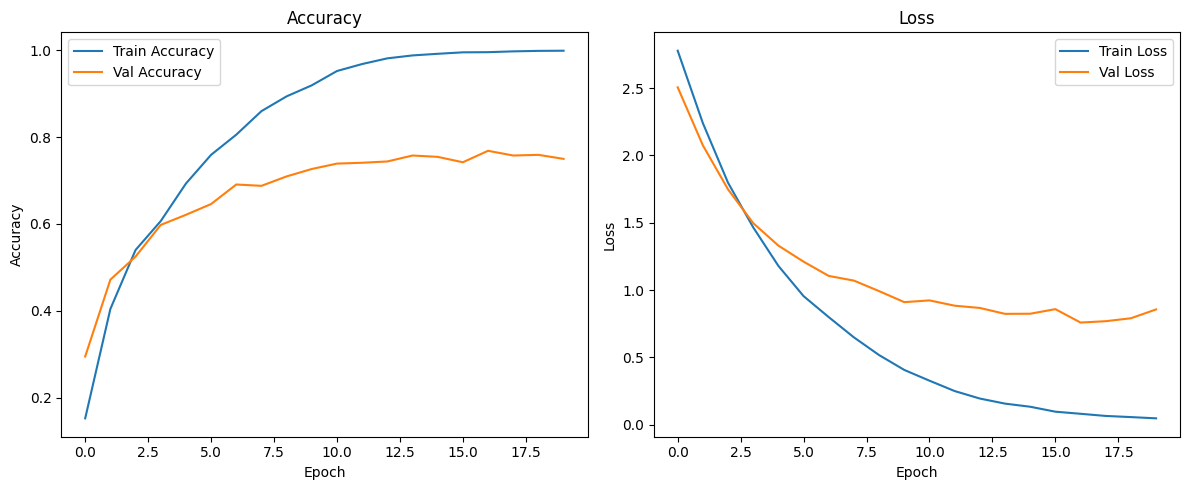

In [ ]:
test_aug_images = np.load('/kaggle/working/test_aug_images.npy', mmap_mode='r')
test_aug_labels = np.load('/kaggle/working/test_aug_labels.npy')
test_aug_labels_one_hot = to_categorical(test_aug_labels, num_classes)

loss, accuracy = model.evaluate(test_aug_images, test_aug_labels_one_hot, verbose=1)
print(f"Test Augmented Accuracy: {accuracy * 100:.2f}%")
print(f"Test Augmented Loss: {loss:.4f}")

model.save('/kaggle/working/model_augmented.h5')
print("Saved trained augmented model to /kaggle/working/model_augmented.h5")

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



# Visualize first 5 categories augmented images AFTER splitting (training split)

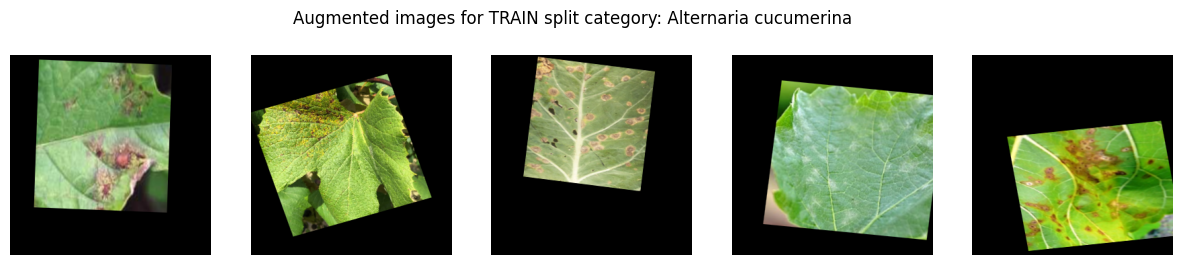

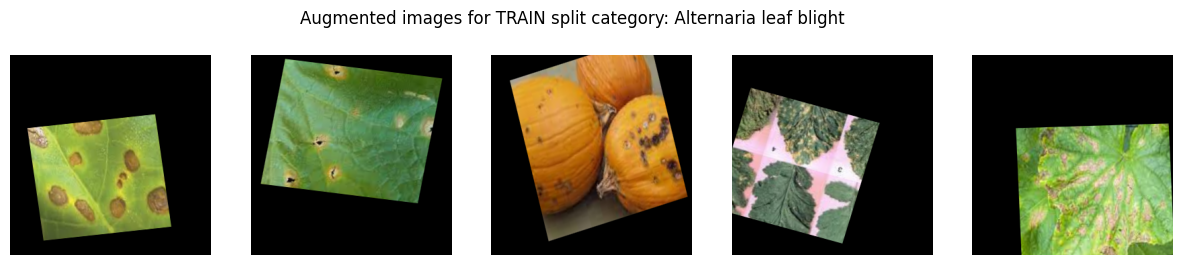

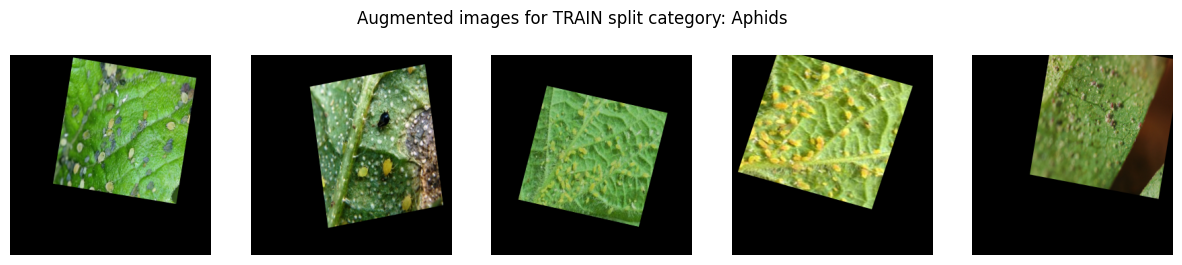

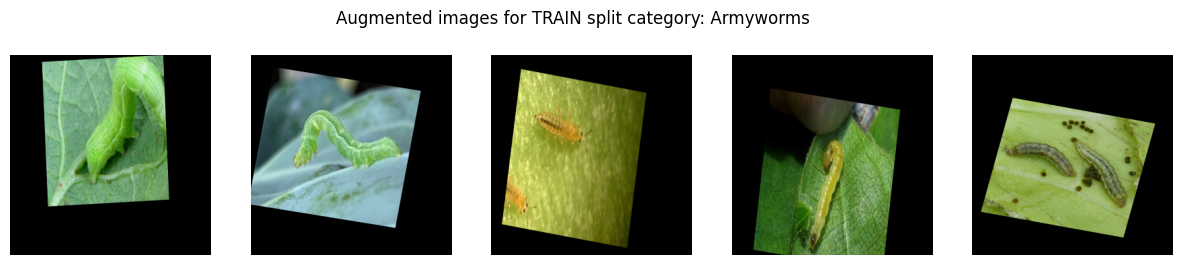

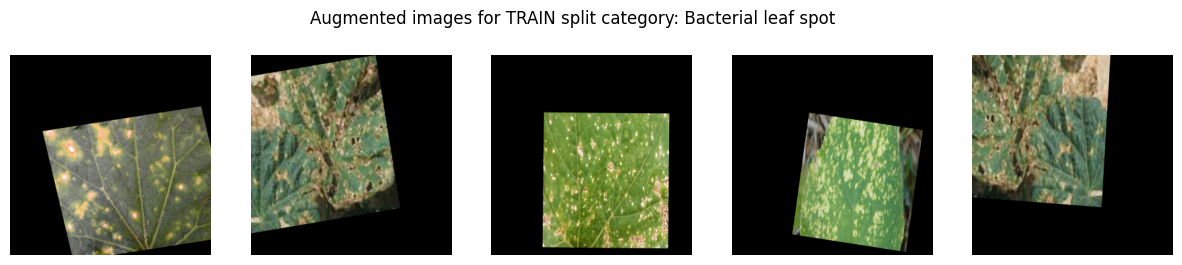

In [ ]:
augmented_images_train = np.load('/kaggle/working/train_aug_images.npy')
augmented_labels_train = np.load('/kaggle/working/train_aug_labels.npy')

with open('/kaggle/working/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)
categories = label_encoder.classes_

samples_per_category = 5

for cat in categories[:5]:
    cat_idx = label_encoder.transform([cat])[0]
    idxs = np.where(augmented_labels_train == cat_idx)[0][:samples_per_category]

    if len(idxs) == 0:
        print(f"No samples found for category '{cat}' in training split.")
        continue

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(idxs):
        plt.subplot(1, samples_per_category, i + 1)
        plt.imshow(augmented_images_train[idx])
        plt.axis('off')
    plt.suptitle(f'Augmented images for TRAIN split category: {cat}')
    plt.show()
